In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F
from torch.optim import lr_scheduler

import torchvision.utils
from torchvision import models
import random
import math
import copy
from PIL import Image
from tqdm import tqdm

#from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization
from torch.utils.data import DataLoader, SubsetRandomSampler, SequentialSampler
from torchvision import datasets, transforms
import os
import cv2
import time

#from dataset import *
from dataset_2 import *

import matplotlib.pyplot as plt
%matplotlib inline

d:\miniconda\envs\zack\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'cv2'

In [2]:
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path
from PIL import Image
import os

class video_Dataset(Dataset):
    def __init__(self, root_dir, label_dir, frame, transform=None):
        self.root_dir = Path(root_dir)
        self.x = []
        self.y = []
        self.transform = transform
        
        self.label_dir = label_dir
        self.frame = frame
        self.folder_name = []
        for fold in os.listdir(root_dir):
            self.folder_name.append(root_dir + '\\' + fold)
        #self.num_classes = 0
        
        self.df = pd.read_excel(self.label_dir, index_col = 'VideoId')
        
        for i, _dir in enumerate(self.root_dir.glob('*')):
            temp = 0
            count = 0
            image_seq = []
            label = []
            tmp_str = str(os.path.dirname(_dir))+"\\"   #windows用的是"\",linux用的是"/"這一點要特別清楚，還有就是在寫路徑時用"\\"才表示一個"\"。
            #print("before: "+str(tmp_str))
            tmp_str = str(_dir).replace(tmp_str, "") 
            tmp_str = tmp_str[2:-4]
            #print(tmp_str)
            
            for file in _dir.glob('*'):
                if(count < self.frame):
                    img = Image.open(file)
                    # 將影像切成下半身2/3
                    #width, height = img.size
                    #img = img.crop((0, height//3, width, height))
                    image_seq.append(self.transform(img))
                    count += 1
                else:
                    image_seq = torch.stack(image_seq)
                    self.x.append(image_seq)
                    label1, label2 = self.df.loc[tmp_str]['mds_updrs_left'], self.df.loc[tmp_str]['mds_updrs_right']
                    label.append(int(label1))
                    label.append(int(label2))
                    self.y.append(label)
                    label = []
                    image_seq = []
                    count = 0
                    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [3]:
def train_model(model, criterion, device, dataloaders, dataset_sizes, optimizer, scheduler, num_epochs):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_loss, valid_loss = [], []
  train_acc, valid_acc = [], []

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        #print('train')
        model.train()
      else:
        #print('val')
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0
    
      # Iterate over data.
      for inputs, labels in tqdm(dataloaders[phase]):
        inputs = inputs.to(device)
        labels = labels[0].to(device)
        
        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
                # zero the parameter gradients
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        torch.cuda.empty_cache()  # release cache in cuda
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      if phase == 'train':
        train_loss.append(epoch_loss)
        train_acc.append(float(epoch_acc))
      else:
        valid_loss.append(epoch_loss)
        valid_acc.append(float(epoch_acc))

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())


  plt.figure(0)
  plt.plot(range(1,num_epochs+1,1), np.array(train_loss), 'r-', label= "train loss") #relative global step
  plt.plot(range(1,num_epochs+1,1), np.array(valid_loss), 'b-', label= "eval loss") #--evaluate_during_training True 在啟用eval
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.savefig(f"./train_val_loss_left.png")

  plt.figure(3)
  plt.plot(range(1,num_epochs+1,1), np.array(train_acc), 'r-', label= "train acc") #relative global step
  plt.plot(range(1,num_epochs+1,1), np.array(valid_acc), 'b-', label= "eval acc") 
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.savefig(f"./train_val_acc_left.png")

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  torch.save(model.state_dict(), './LA_left.pt')
  #torch.save(model.state_dict(),"model.pt")  # save(model):保存整個模型 / save(model.state_dict()):只保存模型權重
  return model

In [4]:
import torch.utils.data as data
from torchvision import datasets
import xlrd


train_tfm = transforms.Compose([
        transforms.Resize((192, 108)),
        transforms.ToTensor(),
        transforms.Normalize((0.45,0.45,0.45),(0.225,0.225,0.225))
    ])

#train_dir = 'test'
train_dir = 'train_data_pic'
folder_dir = os.path.abspath(os.getcwd())
#folder_dir = os.path.join(folder_dir,'train_data_pic')
folder_dir = os.path.join(folder_dir,train_dir)

#train_set = LA_Dataset(folder_dir, 'LA_mds_updrs_label_20230516update_finish.xls', train_tfm, frame = 30)
train_set = video_Dataset(folder_dir, 'LA_mds_updrs_label_20230516update_finish.xls', transform=train_tfm, frame=1)
#train_loader = DataLoader(train_set, batch_size = 2, shuffle = False, num_workers = 0)
#train_loader = DataLoader(train_set, batch_size = 1, shuffle = False, num_workers = 0)

In [5]:
# Random split
batch_size = 1
torch.manual_seed(torch.initial_seed())
datasets = {}
train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size
datasets['train'], datasets['val'] = data.random_split(train_set, [train_set_size, valid_set_size])
dataloaders = {x:DataLoader(datasets[x],batch_size= batch_size, pin_memory=True,  shuffle=True, num_workers=0) for x in ['train','val']}

print('='*30)
print('Train data set:', len(datasets['train']))
print('Valid data set:', len(datasets['val']))

Train data set: 15489
Valid data set: 3873


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetLSTM(nn.Module):
    def __init__(self, resnet_hidden_size, lstm_hidden_size, num_classes):
        super(ResNetLSTM, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # 移除頂層全連接層
        self.resnet_hidden_size = resnet_hidden_size

        self.lstm = nn.LSTM(resnet_hidden_size, lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, num_classes)
        

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        x = x.view(-1, C, H, W)

        resnet_output = self.resnet(x)  # 經過 ResNet 特徵提取
        #print(resnet_output.shape)
        resnet_output = resnet_output.view(batch_size, timesteps, self.resnet_hidden_size)
        #print(resnet_output.shape)
        lstm_output, _ = self.lstm(resnet_output)  # 使用 LSTM 進行序列建模
        lstm_output = lstm_output[:, -1, :]  # 取最後一個時間步的輸出

        output = self.fc(lstm_output)  # 進行分類

        return output


Running on device: cuda:0


D:\miniconda\envs\zack\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
D:\miniconda\envs\zack\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:31<00:00, 57.02it/s]


train Loss: 0.1540 Acc: 0.7450


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:26<00:00, 144.53it/s]


val Loss: 0.2148 Acc: 0.1352
Epoch 2/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:12<00:00, 61.29it/s]


train Loss: 0.0005 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 186.22it/s]


val Loss: 0.1930 Acc: 0.1542
Epoch 3/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.40it/s]


train Loss: 0.0001 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.23it/s]


val Loss: 0.1436 Acc: 0.1541
Epoch 4/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [03:59<00:00, 64.66it/s]


train Loss: 0.0001 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.79it/s]


val Loss: 0.1942 Acc: 0.1439
Epoch 5/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.46it/s]


train Loss: 0.0001 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.27it/s]


val Loss: 0.2336 Acc: 0.1558
Epoch 6/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.32it/s]


train Loss: 0.0001 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 184.73it/s]


val Loss: 0.2196 Acc: 0.1605
Epoch 7/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:12<00:00, 61.29it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 186.49it/s]


val Loss: 0.2473 Acc: 0.1467
Epoch 8/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:13<00:00, 61.07it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.31it/s]


val Loss: 0.1812 Acc: 0.1482
Epoch 9/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:12<00:00, 61.25it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.59it/s]


val Loss: 0.1871 Acc: 0.1558
Epoch 10/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:14<00:00, 60.94it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.19it/s]


val Loss: 0.1928 Acc: 0.1502
Epoch 11/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:13<00:00, 60.99it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.26it/s]


val Loss: 0.1831 Acc: 0.1477
Epoch 12/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:13<00:00, 61.17it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.83it/s]


val Loss: 0.3171 Acc: 0.1474
Epoch 13/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:13<00:00, 61.21it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.67it/s]


val Loss: 0.1989 Acc: 0.1619
Epoch 14/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:05<00:00, 63.02it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:21<00:00, 184.15it/s]


val Loss: 0.2158 Acc: 0.1615
Epoch 15/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:03<00:00, 63.74it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 186.03it/s]


val Loss: 0.2874 Acc: 0.1516
Epoch 16/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.40it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 184.85it/s]


val Loss: 0.2355 Acc: 0.1376
Epoch 17/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:02<00:00, 63.78it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:21<00:00, 183.94it/s]


val Loss: 0.1603 Acc: 0.1396
Epoch 18/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.53it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 186.14it/s]


val Loss: 0.1750 Acc: 0.1497
Epoch 19/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:01<00:00, 64.04it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 184.75it/s]


val Loss: 0.1661 Acc: 0.1537
Epoch 20/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:02<00:00, 63.88it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 186.24it/s]


val Loss: 0.1314 Acc: 0.1594
Epoch 21/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.27it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 184.45it/s]


val Loss: 0.1400 Acc: 0.1489
Epoch 22/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.52it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.02it/s]


val Loss: 0.2596 Acc: 0.1428
Epoch 23/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.30it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.45it/s]


val Loss: 0.2042 Acc: 0.1564
Epoch 24/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:03<00:00, 63.70it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:23<00:00, 164.69it/s]


val Loss: 0.2484 Acc: 0.1397
Epoch 25/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:21<00:00, 59.29it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:23<00:00, 164.09it/s]


val Loss: 0.1489 Acc: 0.1573
Epoch 26/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:16<00:00, 60.37it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.46it/s]


val Loss: 0.1595 Acc: 0.1579
Epoch 27/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:01<00:00, 64.12it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.92it/s]


val Loss: 0.1997 Acc: 0.1493
Epoch 28/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.33it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 184.44it/s]


val Loss: 0.1768 Acc: 0.1459
Epoch 29/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.29it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 186.71it/s]


val Loss: 0.1158 Acc: 0.1533
Epoch 30/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.47it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 184.61it/s]


val Loss: 0.2529 Acc: 0.1526
Epoch 31/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.40it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 184.77it/s]


val Loss: 0.1908 Acc: 0.1592
Epoch 32/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.39it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 186.78it/s]


val Loss: 0.1509 Acc: 0.1493
Epoch 33/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:01<00:00, 64.21it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 184.62it/s]


val Loss: 0.2277 Acc: 0.1582
Epoch 34/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.40it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 186.35it/s]


val Loss: 0.1837 Acc: 0.1553
Epoch 35/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.43it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 186.93it/s]


val Loss: 0.1365 Acc: 0.1464
Epoch 36/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.44it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.98it/s]


val Loss: 0.1801 Acc: 0.1430
Epoch 37/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.43it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.54it/s]


val Loss: 0.2008 Acc: 0.1524
Epoch 38/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.52it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.36it/s]


val Loss: 0.3241 Acc: 0.1336
Epoch 39/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.28it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:21<00:00, 182.70it/s]


val Loss: 0.2314 Acc: 0.1605
Epoch 40/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:00<00:00, 64.39it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:20<00:00, 185.15it/s]


val Loss: 0.2574 Acc: 0.1634
Epoch 41/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:13<00:00, 61.17it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:22<00:00, 170.02it/s]


val Loss: 0.1791 Acc: 0.1326
Epoch 42/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:13<00:00, 61.14it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:22<00:00, 170.31it/s]


val Loss: 0.1392 Acc: 0.1557
Epoch 43/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:13<00:00, 61.16it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:22<00:00, 170.41it/s]


val Loss: 0.1493 Acc: 0.1540
Epoch 44/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:13<00:00, 61.13it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:22<00:00, 169.78it/s]


val Loss: 0.2569 Acc: 0.1567
Epoch 45/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:13<00:00, 61.22it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:22<00:00, 171.59it/s]


val Loss: 0.1328 Acc: 0.1509
Epoch 46/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:13<00:00, 60.98it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:22<00:00, 169.02it/s]


val Loss: 0.2102 Acc: 0.1538
Epoch 47/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:13<00:00, 61.18it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:22<00:00, 170.28it/s]


val Loss: 0.1518 Acc: 0.1441
Epoch 48/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:12<00:00, 61.24it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:22<00:00, 169.01it/s]


val Loss: 0.2082 Acc: 0.1517
Epoch 49/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:12<00:00, 61.22it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:22<00:00, 169.69it/s]


val Loss: 0.2209 Acc: 0.1470
Epoch 50/50
----------


100%|████████████████████████████████████████████████████████████████████████████| 15489/15489 [04:13<00:00, 61.16it/s]


train Loss: 0.0000 Acc: 0.8000


100%|█████████████████████████████████████████████████████████████████████████████| 3873/3873 [00:22<00:00, 170.33it/s]


val Loss: 0.1874 Acc: 0.1418
Training complete in 223m 35s
Best val Acc: 0.163361


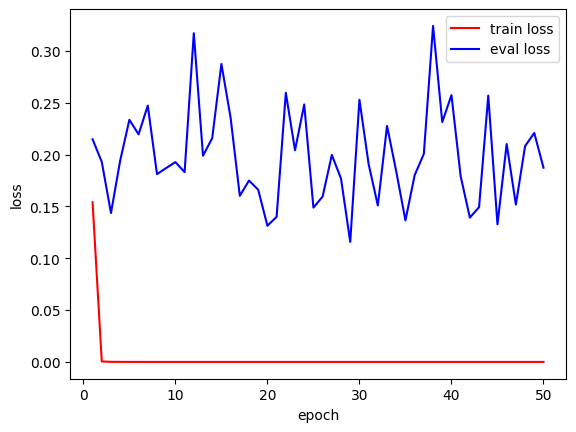

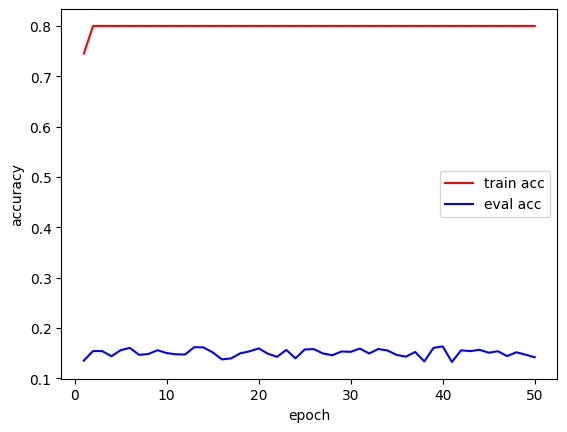

In [8]:
import torchvision.models as models
#timesteps = 30
num_classes = 4
resnet_hidden_size = 512  #resnet18,34 都是512 ; resnet50:2048

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

model = ResNetLSTM(resnet_hidden_size=resnet_hidden_size, lstm_hidden_size=256, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
dataset_sizes = {x: len(train_set) for x in ['train','val']}

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(
        model,
        criterion,
        device,
        dataloaders,
        dataset_sizes,
        optimizer_ft,
        exp_lr_scheduler,
        num_epochs = 50
  )
  